In [1]:
from pyspark.sql import SparkSession


# 检查是否已有 SparkSession，如果没有则创建
if 'spark' not in globals():
    spark = SparkSession.builder \
        .appName("flightProblem") \
        .getOrCreate()

# 加载航班数据（假设数据存储在 HDFS 或本地文件系统）
data = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("hdfs://localhost:9000/airport")

# 选取问题所需特征
dropList = ['FlightNum', 'ArrDelay']
# 选出所需特征列
stats = data.select([column for column in data.columns if column in dropList])
# 清洗数据
stats = stats[~stats['ArrDelay'].isin(['NA'])]
# 展示结果
stats.orderBy(-stats['ArrDelay']).show(10)

+---------+--------+
|FlightNum|ArrDelay|
+---------+--------+
|      808|    2461|
|     1699|    2453|
|     1107|    1951|
|     3538|    1707|
|      357|    1655|
|      512|    1583|
|     1472|    1542|
|     2398|    1525|
|      804|    1510|
|     1743|    1490|
+---------+--------+
only showing top 10 rows



+-------------+----------+------------+------------------+
|UniqueCarrier|DelayTimes|NoDelayTimes|         DelayRate|
+-------------+----------+------------+------------------+
|           UA|    200470|      237509|0.8440522253893536|
|           AA|    293277|      292208|1.0036583529540601|
|           NW|    158797|      185313|0.8569123590897563|
|           EV|    122751|      152116| 0.806956533172053|
|           B6|     83202|      108912|0.7639378580872631|
|           DL|    209018|      234916|0.8897563384358664|
|           OO|    219367|      334045|0.6566989477465611|
|           F9|     46836|       48548|0.9647359314492873|
|           YV|    111004|      134127|0.8276036890409836|
|           US|    167945|      278141| 0.603812454834059|
|           AQ|      1908|        5844|0.3264887063655031|
|           MQ|    205765|      265396| 0.775313117002517|
|           OH|     96154|       94541|1.0170613807765942|
|           HA|     18736|       42476|0.441096148413221

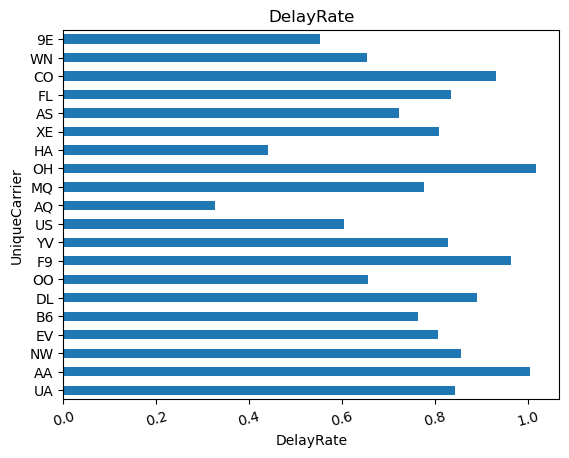

In [2]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import numpy as np
import pyspark.sql.functions as F


if 'spark' not in globals():
    spark = SparkSession.builder \
        .appName("flightProblem") \
        .getOrCreate()

data = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("hdfs://localhost:9000/airport")


# 构建延误率计算的数据集
def rateOfDelay():
    # 定义需要保留的列
    dropList = ['UniqueCarrier', 'ArrDelay']

    # 选取保留列作为初始数据集
    stats = data.select(
        [column for column in data.columns if column in dropList])

    # 过滤掉 `ArrDelay` 列中值为 'NA' 的行
    stats = stats[~stats['ArrDelay'].isin(['NA'])]

    # 筛选延误时间大于 0 的航班，并按航空公司分组统计数量
    statsDelay = stats.where(stats['ArrDelay'] > 0).groupBy(
        'UniqueCarrier').count()

    # 筛选延误时间小于等于 0 的航班，并按航空公司分组统计数量
    statsNodelay = stats.where(stats['ArrDelay'] <= 0).groupBy(
        'UniqueCarrier').count()

    # 重命名未延误航班统计列
    statsNodelay = statsNodelay.withColumnRenamed('count', 'NoDelayTimes')

    # 重命名延误航班统计列
    statsDelay = statsDelay.withColumnRenamed('count', 'DelayTimes')

    # 合并延误航班和未延误航班的统计结果
    statsMerge = statsDelay.join(
        statsNodelay, on='UniqueCarrier', how='left_outer')

    # 计算延误率，避免分母为 0 的情况
    statsMerge = statsMerge.withColumn(
        'DelayRate',
        F.when(statsMerge['NoDelayTimes'] != 0, statsMerge['DelayTimes'] /
               statsMerge['NoDelayTimes']).otherwise(1)
    )

    # 展示结果
    statsMerge.show()

    # 返回合并后的数据集
    return statsMerge


# 绘制延误率柱状图
def reverseCapture():
    # 获取延误率统计数据并转换为 pandas DataFrame
    statsMerge = rateOfDelay()
    pandasDelay = statsMerge.toPandas()

    # 绘制水平柱状图
    pandasDelay.DelayRate.plot(kind='barh')

    # 设置 x 轴标签为延误率
    plt.xlabel('DelayRate')

    # 设置 y 轴标签为航空公司
    plt.ylabel('UniqueCarrier')

    # 设置 y 轴刻度为航空公司名称
    a = np.arange(len(pandasDelay.UniqueCarrier))
    plt.yticks(a, pandasDelay.UniqueCarrier)

    # 设置 x 轴刻度旋转角度
    plt.xticks(rotation=15)

    # 设置标题
    plt.title("DelayRate")

    # 显示图表
    plt.show()


reverseCapture()

+----+-----+----------+---------+----------------+
|Year|Month|DayofMonth|DayOfWeek|maxDelayInOneDay|
+----+-----+----------+---------+----------------+
|2008|    1|         1|        2|              99|
|2008|    1|         2|        3|              99|
|2008|    1|         3|        4|              99|
|2008|    1|         4|        5|              99|
|2008|    1|         5|        6|              99|
|2008|    1|         6|        7|              99|
|2008|    1|         7|        1|              99|
|2008|    1|         8|        2|              99|
|2008|    1|         9|        3|              99|
|2008|    1|        10|        4|              99|
|2008|    1|        11|        5|              99|
|2008|    1|        12|        6|              98|
|2008|    1|        13|        7|              99|
|2008|    1|        14|        1|              99|
|2008|    1|        15|        2|              99|
|2008|    1|        16|        3|              99|
|2008|    1|        17|        

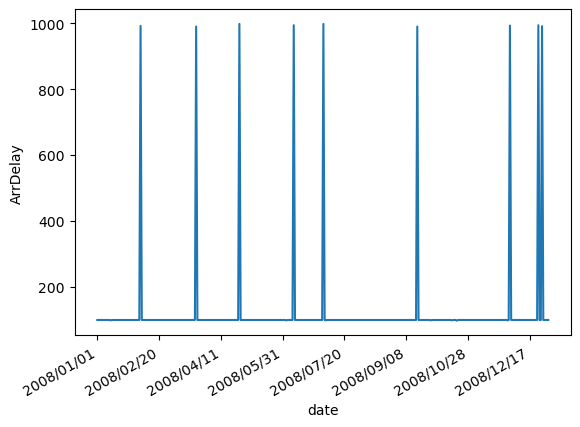

In [3]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import matplotlib.dates as mdate
import pandas as pd


if 'spark' not in globals():
    spark = SparkSession.builder \
        .appName("flightProblem") \
        .getOrCreate()

data = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("hdfs://localhost:9000/airport")

# 定义需要保留的列
dropList = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'ArrDelay']

# 选择需要的特征列作为初始数据集
stats = data.select([column for column in data.columns if column in dropList])

# 过滤掉 `ArrDelay` 列中值为 'NA' 的行
stats = stats[~stats['ArrDelay'].isin(['NA'])]

# 按天聚合航班数据，计算每天的最大延误时间并加入新列 `maxDelayInOneDay`
statsDay = stats.groupBy('Year', 'Month', 'DayofMonth', 'DayOfWeek') \
    .agg(F.max('ArrDelay').alias('maxDelayInOneDay'))

# 对聚合后的数据按日期升序排列
statsDay = statsDay.orderBy('Year', 'Month', 'DayofMonth')

# 展示前 50 行结果
statsDay.show(50)

# 将聚合结果转换为 pandas DataFrame
pandasDelay = statsDay.toPandas()

# 确保 `maxDelayInOneDay` 列为数值类型
pandasDelay['maxDelayInOneDay'] = pd.to_numeric(
    pandasDelay['maxDelayInOneDay'], errors='coerce')

# 检查转换后是否有 NaN 值（可能由无效数据导致）
if pandasDelay['maxDelayInOneDay'].isna().any():
    print("Warning: Detected NaN values in maxDelayInOneDay. These rows will be dropped.")
    pandasDelay = pandasDelay.dropna(subset=['maxDelayInOneDay'])

# 绘制最大延误时间的折线图
pandasDelay.maxDelayInOneDay.plot()

# 设置 x 轴日期格式为 '2008/月/日'
plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('2008/%m/%d'))

# 自动调整日期标签角度以防止重叠
plt.gcf().autofmt_xdate()

# 设置 x 轴标签为日期
plt.xlabel('date')

# 设置 y 轴标签为到达延误时间
plt.ylabel('ArrDelay')

# 显示图表
plt.show()

+-------+-----------------+
|weekNum|maxDelayInOneWeek|
+-------+-----------------+
|      0|               99|
|      1|               99|
|      2|               99|
|      3|               99|
|      4|               99|
|      5|              992|
|      6|               99|
|      7|               99|
|      8|               99|
|      9|               99|
|     10|               99|
|     11|              990|
|     12|               99|
|     13|               99|
|     14|               99|
|     15|               99|
|     16|              998|
|     17|               99|
|     18|               99|
|     19|               99|
|     20|               99|
|     21|               99|
|     22|              994|
|     23|               99|
|     24|               99|
|     25|               99|
|     26|              998|
|     27|               99|
|     28|               99|
|     29|               99|
|     30|               99|
|     31|               99|
|     32|           

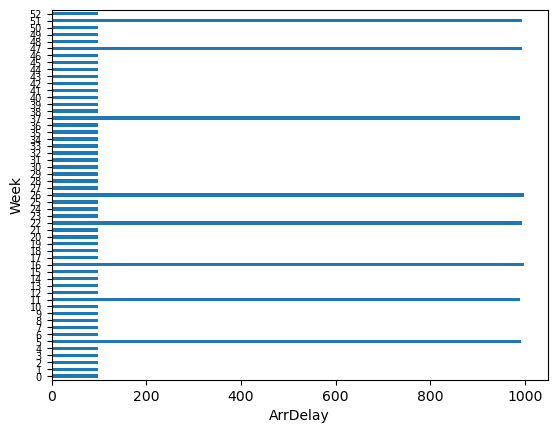

In [4]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import concat_ws
import matplotlib.pyplot as plt
import pandas as pd


if 'spark' not in globals():
    spark = SparkSession.builder \
        .appName("flightProblem") \
        .getOrCreate()

data = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("hdfs://localhost:9000/airport")

# 定义要保留的列名
dropList = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'ArrDelay']

# 从数据集中选取保留的特征列
stats = data.select([column for column in data.columns if column in dropList])

# 清洗数据，过滤掉 `ArrDelay` 列中值为 'NA' 的行
stats = stats[~stats['ArrDelay'].isin(['NA'])]

# 按日期分组，计算每天的最大到达延误时间
statsDay = stats.groupBy('Year', 'Month', 'DayofMonth', 'DayOfWeek').agg(
    F.max('ArrDelay').alias('maxDelayInOneDay')
)

# 对结果按日期排序
statsDay = statsDay.orderBy('Year', 'Month', 'DayofMonth')

# 创建新的列 `date`，将年、月、日连接成日期格式
df = statsDay.withColumn('date', concat_ws(
    '-', statsDay['Year'], statsDay['Month'], statsDay['DayofMonth']))

# 设置初始年份为 2008
initial_date = 2008

# 选择需要的列进行计算
df = df.select('maxDelayInOneDay', 'date')

# 计算年数、月数、天数和周数
df2 = df.withColumn(
    'yearCal',
    F.year('date') - initial_date
).withColumn(
    'monthCal',
    F.month('date') + F.col('yearCal') * 12
).withColumn(
    'dayCal',
    F.datediff('date', F.lit('%s-01-01' % initial_date)) + 1
).withColumn(
    'weekNum',
    (F.col('dayCal') / 7).cast('int')
)

# 选择所需列并按周数分组，统计每周的最大延误时间
statsWeek = df2.select('maxDelayInOneDay', 'date', 'weekNum')
statsWeek = statsWeek.groupBy('weekNum').agg(
    F.max('maxDelayInOneDay').alias('maxDelayInOneWeek')
)

# 展示前 50 行结果
statsWeek.orderBy('weekNum').show(50)

# 转换为 pandas DataFrame 以便绘制柱状图
pandasDelay = statsWeek.toPandas()

# 确保 `maxDelayInOneWeek` 列为数值类型
pandasDelay['maxDelayInOneWeek'] = pd.to_numeric(
    pandasDelay['maxDelayInOneWeek'], errors='coerce')

# 检查并处理缺失值
if pandasDelay['maxDelayInOneWeek'].isna().any():
    print("Warning: Detected NaN values in maxDelayInOneWeek. These rows will be dropped.")
    pandasDelay = pandasDelay.dropna(subset=['maxDelayInOneWeek'])

# 绘制延误时间的水平柱状图
pandasDelay.maxDelayInOneWeek.plot(kind='barh')

# 设置 x 轴标签为到达延误时间
plt.xlabel('ArrDelay')

# 设置 y 轴标签为周数
plt.ylabel('Week')

# 设置 y 轴刻度字体大小
plt.yticks(fontsize=7)

# 显示图表
plt.show()

+----------+---------+-----------+-------+----------+
|FlightType|CancelNum|NoCancelNum|  Total|CancelRate|
+----------+---------+-----------+-------+----------+
|         1|    63400|    3892390|3955790|  0.016027|
|         0|    74034|    2979904|3053938|  0.024242|
+----------+---------+-----------+-------+----------+



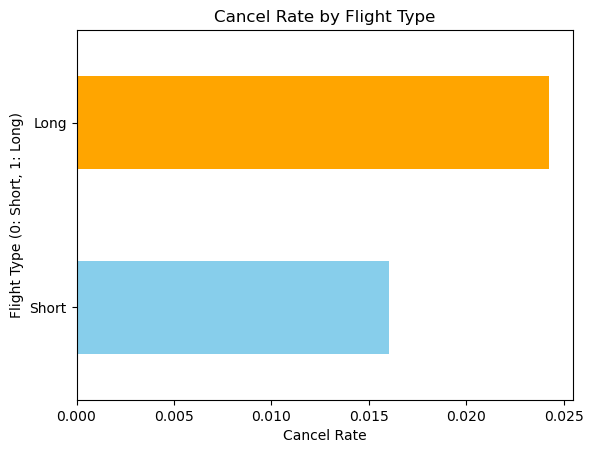

In [5]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import bround
import matplotlib.pyplot as plt


if 'spark' not in globals():
    spark = SparkSession.builder \
        .appName("flightProblem") \
        .getOrCreate()

data = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("hdfs://localhost:9000/airport")

# 将 Cancelled 列显式转换为整数类型，以避免类型问题
data = data.withColumn('Cancelled', data['Cancelled'].cast('int'))


def badCancelRate():
    # 选取所需列，并添加 FlightType 列用于航班分类
    # 0 表示短程航班，1 表示长程航班。
    stats = data.select('Distance', 'Cancelled')
    stats = stats.withColumn('FlightType', F.when(
        stats['Distance'] <= 500, 0).otherwise(1))

    # 按 FlightType 统计取消航班数目
    statsCancel = stats.where(
        stats['Cancelled'] == 1).groupBy('FlightType').count()
    statsCancel = statsCancel.withColumnRenamed('count', 'CancelNum')

    # 按 FlightType 统计未取消航班数目
    statsNocancel = stats.where(
        stats['Cancelled'] == 0).groupBy('FlightType').count()
    statsNocancel = statsNocancel.withColumnRenamed('count', 'NoCancelNum')

    # 合并取消和未取消统计数据
    statsMerge = statsCancel.join(
        statsNocancel, on='FlightType', how='left_outer')

    # 计算总航班数和取消率
    statsMerge = statsMerge.withColumn(
        'Total', statsMerge['CancelNum'] + statsMerge['NoCancelNum'])
    statsMerge = statsMerge.withColumn('CancelRate', bround(
        statsMerge['CancelNum'] / statsMerge['Total'], scale=6))

    # 打印结果到控制台
    statsMerge.show()

    # 返回结果 DataFrame
    return statsMerge


def reverseCapture():
    # 获取航班取消率数据
    statsMerge = badCancelRate()

    # 将 Spark DataFrame 转换为 Pandas DataFrame
    pandasDelay = statsMerge.toPandas()

    # 绘制取消率柱状图
    pandasDelay['CancelRate'].plot(kind='barh', color=['skyblue', 'orange'])
    plt.xlabel('Cancel Rate')
    plt.ylabel('Flight Type (0: Short, 1: Long)')
    plt.title("Cancel Rate by Flight Type")
    plt.yticks([0, 1], ['Short', 'Long'])
    plt.show()


# 执行数据分析并绘制图表
reverseCapture()